# Import libs

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torchvision

# dtype = torch.cuda.FloatTensor

In [2]:
# 以下函数均来自Deep image prior，最近在做它的毕业论文就顺便拿来用了哈哈哈哈

def crop_image(img, d=32):
    '''Make dimensions divisible by `d`'''

    new_size = (img.size[0] - img.size[0] % d, 
                img.size[1] - img.size[1] % d)

    bbox = [
            int((img.size[0] - new_size[0])/2), 
            int((img.size[1] - new_size[1])/2),
            int((img.size[0] + new_size[0])/2),
            int((img.size[1] + new_size[1])/2),
    ]

    img_cropped = img.crop(bbox)
    return img_cropped

def get_image_grid(images_np, nrow=8):
    '''Creates a grid from a list of images by concatenating them.'''
    images_torch = [torch.from_numpy(x) for x in images_np]
    torch_grid = torchvision.utils.make_grid(images_torch, nrow)
    
    return torch_grid.numpy()

def plot_image_grid(images_np, nrow =8, factor=1, interpolation='lanczos'):
    """Draws images in a grid
    
    Args:
        images_np: list of images, each image is np.array of size 3xHxW of 1xHxW
        nrow: how many images will be in one row
        factor: size if the plt.figure 
        interpolation: interpolation used in plt.imshow
    """
    n_channels = max(x.shape[0] for x in images_np)
    assert (n_channels == 3) or (n_channels == 1), "images should have 1 or 3 channels"
    
    images_np = [x if (x.shape[0] == n_channels) else np.concatenate([x, x, x], axis=0) for x in images_np]

    grid = get_image_grid(images_np, nrow)
    
    plt.figure(figsize=(len(images_np) + factor, 12 + factor))
    
    if images_np[0].shape[0] == 1:
        plt.imshow(grid[0], cmap='gray', interpolation=interpolation)
    else:
        plt.imshow(grid.transpose(1, 2, 0), interpolation=interpolation)
    
    plt.show()
    
    return grid

def load(path):
    """Load PIL image."""
    img = Image.open(path)
    return img

def get_image(path, imsize=-1):
    """Load an image and resize to a cpecific size. 

    Args: 
        path: path to image
        imsize: tuple or scalar with dimensions; -1 for `no resize`
    """
    img = load(path)

    if isinstance(imsize, int):
        imsize = (imsize, imsize)

    if imsize[0]!= -1 and img.size != imsize:
        if imsize[0] > img.size[0]:
            img = img.resize(imsize, Image.BICUBIC)
        else:
            img = img.resize(imsize, Image.ANTIALIAS)

    img_np = pil_to_np(img)

    return img, img_np

def pil_to_np(img_PIL):
    '''Converts image in PIL format to np.array.
    
    From W x H x C [0...255] to C x W x H [0..1]
    '''
    ar = np.array(img_PIL)

    if len(ar.shape) == 3:
        ar = ar.transpose(2,0,1)
    else:
        ar = ar[None, ...]

    return ar.astype(np.float32) / 255.

def np_to_pil(img_np): 
    '''Converts image in np.array format to PIL image.
    
    From C x W x H [0..1] to  W x H x C [0...255]
    '''
    ar = np.clip(img_np*255,0,255).astype(np.uint8)
    
    if img_np.shape[0] == 1:
        ar = ar[0]
    else:
        ar = ar.transpose(1, 2, 0)

    return Image.fromarray(ar)

def np_to_torch(img_np):
    '''Converts image in numpy.array to torch.Tensor.

    From C x W x H [0..1] to  C x W x H [0..1]
    '''
    return torch.from_numpy(img_np)[None, :]

def torch_to_np(img_var):
    '''Converts an image in torch.Tensor format to np.array.

    From 1 x C x W x H [0..1] to  C x W x H [0..1]
    '''
    return img_var.detach().cpu().numpy()[0]

In [3]:
fname = 'data/denoising/jialun1.jpg'
# fname = 'data/denoising/jialun2.jfif'

# Load image

(3, 288, 224)


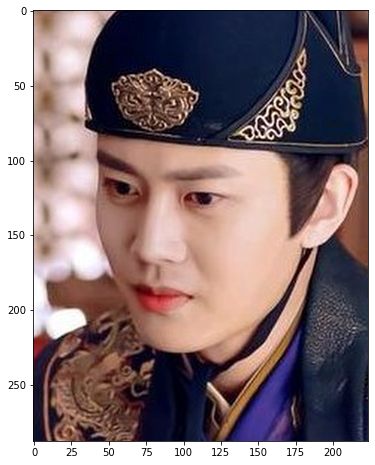

In [4]:
img_pil = crop_image(get_image(fname, -1)[0], d=32)
img_np = pil_to_np(img_pil)
print(img_np.shape)  # 一定要保证图片通道数为1或3
plot_image_grid([img_np], 4, 5);

In [5]:
stride = int(img_np.shape[1] / 55)
print(stride)
m = nn.AvgPool2d(stride)
img_np_torch = np_to_torch(img_np)#.type(dtype)
out = m(img_np_torch)
out.shape

5


torch.Size([1, 3, 57, 44])

(3, 57, 44)


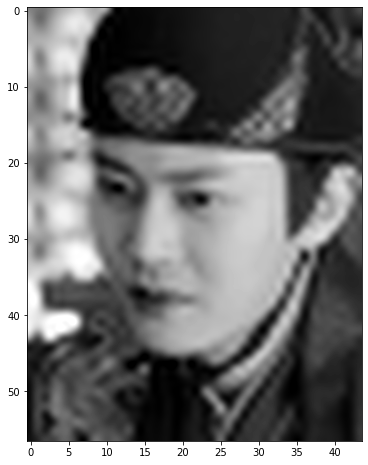

In [6]:
a = torch_to_np(out)
print(a.shape)
plot_image_grid([a[1].reshape(1, out.shape[2], out.shape[3])], 4, 5);

In [7]:
# file_write_obj = open("test.txt", 'w')
draw = a[1]
# change = "@%#*oa+=-:. "
change = "●◆▲※≡%a+:. "
for i in range(draw.shape[0]):
    s = ""
    for j in range(draw.shape[1]):
        key = int(draw[i][j] * 10)
        s += change[key]
        if key > 4:
            s += " "
    print(s)
    # file_write_obj.write(s)
    # file_write_obj.write('\n')
# file_write_obj.close()

% ≡≡% a + : + a a % ●●●●●●●●●●●●◆◆◆◆◆◆◆◆◆◆◆◆◆▲◆●◆▲◆◆▲
% ≡≡a + : . : + % ●●●●●●●●●●●●●◆◆◆◆◆◆◆◆◆◆◆◆◆▲▲◆●▲◆◆◆
a % % a : : . : + ▲●●●●●●●●●●●●●◆◆◆◆◆◆◆◆◆◆◆◆◆▲◆▲●◆▲◆◆
a a a + + : : : % ●●●●●●●●●●●●●●◆◆◆◆◆◆◆◆◆◆◆◆◆▲◆◆▲◆※◆●
a a + + + + + + ◆●●●●●●●●●●●●●●◆◆◆◆◆◆◆◆◆◆◆◆▲◆◆◆▲◆※◆▲
+ a a + : : + a ●●●●●●●●●●●●●●●◆◆◆◆◆◆◆◆◆◆◆◆▲※◆◆◆▲※◆※
+ % a : . . : ≡●●●●●●●●●●●●●●●●◆◆◆◆◆◆◆◆◆◆◆≡▲◆◆◆▲▲▲※
+ % a : : . : ※●●●●●●●●●●●●●●●●◆◆◆◆◆◆◆◆◆◆▲※▲◆◆◆◆▲▲▲
+ a a + : : + ◆●●●●◆▲▲※※▲●●●●●●◆◆◆◆◆◆◆◆◆▲▲≡▲◆◆◆◆◆▲▲
a % % a a a a ●●●◆▲※※※※▲※※※◆●●●◆◆◆◆◆◆◆◆◆▲≡≡※◆◆◆◆◆◆◆
% % % a + + + ●●●◆◆▲※≡※◆≡≡※≡▲●●◆◆◆◆◆◆◆◆▲≡≡※▲◆◆●●◆◆◆
% ≡≡a + : : ●●●●▲▲▲※※▲※※※※※◆●●◆◆◆◆◆◆▲≡% ≡≡◆◆●●●◆◆◆
% ≡≡a + : : ◆●●●▲▲※▲※▲▲※※≡※●●●●◆◆◆◆◆≡≡※a ※◆◆●●●●◆◆
% ≡≡% a + + ▲●●●●▲◆▲※▲※※※≡◆●●●●●●◆▲▲≡≡% a ※●●●●●●◆◆
% % % a a ≡% ▲●●●●◆▲▲▲※▲▲※▲●●●●●●◆▲※% ※≡≡% ▲●●●●●●◆◆
a % a a + + a ●●●●●●●▲▲▲※▲◆●●●◆▲◆◆▲≡% ▲% ≡≡a ◆◆●●●●●●◆
+ % % + : : + a ※●●●●●●◆◆◆◆●●●●●●◆▲≡※≡≡% ≡※▲●●●●●●●◆◆
+ % % + + : + a ≡※※※※※※▲▲◆◆◆●●◆●◆◆▲▲※≡※※▲◆◆◆◆◆◆●●◆◆◆
a % % a + + a a ≡※≡≡≡% % % % % a a a % % % ≡≡≡※※※※